<a href="https://colab.research.google.com/github/bomiiisong/AI_Project/blob/master/Modeling/BaseModel_with_snapshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# instagram-crawling 

## 1. Import Packages & Data Load

> ### 1) Import Packages

In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow

> ### 2) Data Load

* Drive Mount

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


* Data check

In [3]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/snapshot.zip'

-rw------- 1 root root 17522249 Apr 12 04:25 '/content/drive/My Drive/Colab Notebooks/datasets/snapshot.zip'


* unzip data

In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/snapshot.zip

## 2. Data Preprocessing

> ### 1) Data Directory 설정

In [5]:
train_dir = 'train'
valid_dir = 'test'
test_dir = 'hold'

> ### 2) Data Nomalization & generator 생성

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(train_dir,target_size = (640, 640),
                                                    batch_size = 17,class_mode = 'categorical')

valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size = (640, 640),
                                                    batch_size = 19,class_mode = 'categorical')

Found 136 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


* generator 생성 결과 확인

In [ ]:
for pred, label in train_generator:
  print(pred.shape)
  print(label.shape)
  print(label)
  break

## 3. Modeling

> ### 1) Transfer Learning (VGG16) Import

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (640, 640, 3))

> ### 2) Fine Tuninning 위해 학습 레이어 설정

In [8]:
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':       
    set_trainable = True

  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 640, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 640, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 320, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 320, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 320, 320, 128)     147584    
______________________________________________________________

> ### 3) VGG16 + DNN Layer 설정

In [9]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation = 'softmax'))   

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 20, 20, 512)       14714688  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 67,144,258
Trainable params: 59,508,994
Non-trainable params: 7,635,264
_________________________________________________________________


> ### 4) Model compile

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

> ### 5) Model fitting

In [10]:
%%time

Hist = model.fit(train_generator, 
                 steps_per_epoch = train_generator.samples // train_generator.batch_size, 
                 epochs = 50, 
                 validation_data = valid_generator,
                 validation_steps=valid_generator.samples // valid_generator.batch_size)

Epoch 1/50
8/8 [==============================] - 87s 4s/step - loss: 0.9992 - accuracy: 0.5259 - val_loss: 0.5889 - val_accuracy: 0.6842
Epoch 2/50
8/8 [==============================] - 10s 1s/step - loss: 0.5987 - accuracy: 0.6784 - val_loss: 0.5112 - val_accuracy: 0.7544
Epoch 3/50
8/8 [==============================] - 11s 1s/step - loss: 0.4301 - accuracy: 0.7700 - val_loss: 0.4710 - val_accuracy: 0.7895
Epoch 4/50
8/8 [==============================] - 10s 1s/step - loss: 0.2560 - accuracy: 0.9188 - val_loss: 0.4427 - val_accuracy: 0.7895
Epoch 5/50
8/8 [==============================] - 10s 1s/step - loss: 0.2148 - accuracy: 0.9114 - val_loss: 0.4581 - val_accuracy: 0.7193
Epoch 6/50
8/8 [==============================] - 10s 1s/step - loss: 0.1388 - accuracy: 0.9814 - val_loss: 0.4717 - val_accuracy: 0.7018
Epoch 7/50
8/8 [==============================] - 10s 1s/step - loss: 0.1119 - accuracy: 0.9542 - val_loss: 0.4471 - val_accuracy: 0.7544
Epoch 8/50
8/8 [==================

> ### 6) 학습 결과 평가

In [11]:
loss, accuracy = model.evaluate(valid_generator)
loss, accuracy

4/4 [==============================] - 14s 4s/step - loss: 0.5500 - accuracy: 0.8125


(0.5499529838562012, 0.8125)

* 결과 시각화

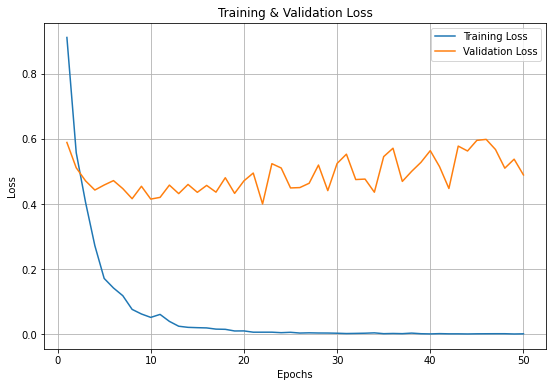

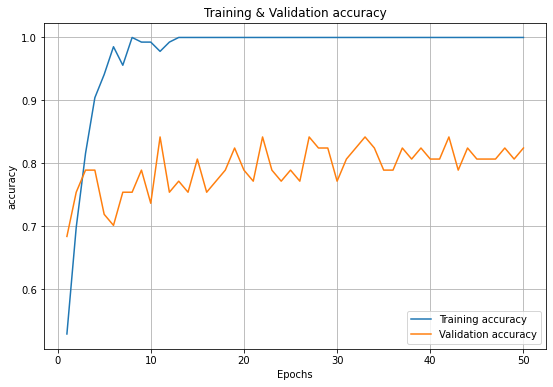

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist.history['loss'])
plt.plot(epochs, Hist.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist.history['accuracy'])
plt.plot(epochs, Hist.history['val_accuracy'])

plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()

## confusion matrix_1Batch

In [ ]:
for pred, label in valid_generator:
  print('prediction: ', pred.shape)
  print('label: ', label.shape)
  break

prediction:  (19, 640, 640, 3)
label:  (19, 2)


## 4. 모델 분류 결과 시각화

> ### 1) 분류할 데이터 경로 저장

In [25]:
import pathlib
from glob import glob

data_root = pathlib.Path(glob('/content/*/')[2])
print(data_root)
# label = ['0','1']

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

/content/test


* random으로 데이터 선택 및 데이터 경로 확인

In [27]:
import random

random.choice(all_image_paths)

'/content/test/0/전신샷그램1347.jpg'

> ### 2) 분류할 데이터의 정답 Label 확인

In [ ]:
import PIL.Image as Image
import matplotlib.pyplot as plt

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12))
for n in range(9):
  image_path = random.choice(all_image_paths)
  plt.subplot(3,3, n+1)
  plt.imshow(plt.imread(image_path))
  idx = image_path.split('/')[-2]
  plt.title(str(idx)) # 1 -> Best , 0 -> Worst
  plt.axis('off')
plt.show()

In [ ]:
import cv2

plt.figure(figsize=((16, 16)))

def softmax(x):
    m = np.max(x)
    sm = np.exp(x - m)/np.sum(np.exp(x - m))
    return sm
  
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

for n in range(9):
    #랜덤 이미지 경로 추출
    image_path = random.choice(all_image_paths)

    #이미지 크기 변경 및 정규화
    img = cv2.imread(image_path)
    # img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0  # 3차원 행렬(224, 224, 3)
    img = np.expand_dims(img, axis=0)  # 4차원 (1, 224, 224, 3)

    # 이미지 분류
    logits = model.predict(img)[0]

    #이미지 출력
    plt.subplot(3,3, n+1)
    plt.imshow(plt.imread(image_path))
    idx = image_path.split('/')[-2]
    plt.title('label: ' + str(idx))
    plt.xlabel(logits)

    # 출력 결과 형태
    # title : Label 0/1
    # image
    # [0으로 분류할 확률, 1로 분류할 확률] -> Softmax 이므로 총합이 1이 되는 두 가지 확률값으로 출력됨